# Logistic Regression for Board Game Success

After the initial EDA for my Capstone 1 project, I have cleaned up a dataset containing around 17.5K board games and can now attempt to build a classifier that identifies whether a board game will be successful. To do this, I will be splitting the target variable (Rating) into a binary classification of successful (1) and unsuccessful (0). Then, I can utilize sklearn's functionality to run a logistic regression to predict which category a given board game should fall under.

## An initial cutoff point for success

The first question I need to answer is where the correct cutoff point for success should be. That is to say, at what rating (or higher) is a board game considered successful? Normally, this would be an answer for a client to answer -- do board games of a given rating tend to make them more money than those of lower rating? Are they aiming for a given rating and wish to build with that rating in mind? 

Given that there is no specific client here, I'll have to choose based on the EDA I carried out in the previous notebook. Let's load in the data and take a look at the distribution of ratings in order to decide on a good cutoff point:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

with open('BGG_NoNaN_DF.pkl', 'rb') as f:
    noNaN_DF = pickle.load(f)

# For now, I'm going to work with the fully cleaned data (noNaN_DF), so I can use all of
# the features.
noNaN_DF.describe()

,ID Num,Rating,Standard Dev,Weight,User Number,Min Playtime,Max Playtime,Year Published,Min Players,Max Players
count,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000,17521.000000
mean,79159.437190,5.742033,1.476525,2.148664,702.807774,68.374122,76.539524,2004.550768,2.028594,4.721078
std,74572.238468,0.401182,0.269365,0.805536,2669.578256,72.908630,80.111220,12.960938,0.637251,2.347712
min,1.000000,3.729410,0.192413,1.000000,23.000000,1.000000,1.000000,1903.000000,1.000000,1.000000
25%,8490.000000,5.523410,1.289610,1.500000,58.000000,30.000000,30.000000,2000.000000,2.000000,4.000000
50%,42220.000000,5.583170,1.439960,2.000000,124.000000,45.000000,60.000000,2009.000000,2.000000,4.000000
75%,149323.000000,5.781040,1.618190,2.684500,378.000000,90.000000,90.000000,2014.000000,2.000000,6.000000
max,249414.000000,8.622630,3.990480,5.000000,76405.000000,960.000000,999.000000,2019.000000,9.000000,20.000000


In [2]:
noNaN_DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17521 entries, Die Macher to Backyard Builders Treehouse
Data columns (total 10 columns):
ID Num            17521 non-null int64
Rating            17521 non-null float64
Standard Dev      17521 non-null float64
Weight            17521 non-null float64
User Number       17521 non-null float64
Min Playtime      17521 non-null float64
Max Playtime      17521 non-null float64
Year Published    17521 non-null float64
Min Players       17521 non-null float64
Max Players       17521 non-null float64
dtypes: float64(9), int64(1)
memory usage: 1.5+ MB


In [3]:
noNaN_DF.quantile([0.75, 0.8, 0.85, 0.9])

,ID Num,Rating,Standard Dev,Weight,User Number,Min Playtime,Max Playtime,Year Published,Min Players,Max Players
0.75,149323.0,5.78104,1.61819,2.6845,378.0,90.0,90.0,2014.0,2.0,6.0
0.80,161438.0,5.88009,1.66772,2.8636,529.0,90.0,120.0,2014.0,2.0,6.0
0.85,173074.0,6.03211,1.72724,3.0000,773.0,120.0,120.0,2015.0,2.0,6.0
0.90,186624.0,6.26280,1.81093,3.2381,1280.0,120.0,180.0,2016.0,3.0,8.0


As seen previously in the EDA notebook, the board game ratings are strongly peaked between 5 and 6. As such, it's not really possible to use an even number like 5 or 6 to be a cutoff for success. I think a good cutoff is the 80th percentile -- saying that if you are in the top 20% of all board games, you are a successful game. This is likely a very conservative value, but that's perhaps better for risk aversion.

Now that we have a cutoff, I can alter the ratings to become a binary classification as mentioned earlier. Now, more specifically, any rating above the 80th percentile will be a success (1) and below will be not be a success (0).

In [4]:
ratings = noNaN_DF['Rating']
ratings80 = np.percentile(noNaN_DF['Rating'], 80)
target = ratings.apply(lambda x: x >= ratings80)
print(target)

Die Macher                                                    True
Dragonmaster                                                 False
Samouraï                                                      True
Tal der Könige                                               False
Acquire                                                       True
Mare Mediterraneum                                           False
Castle City                                                   True
Lords of Creation                                            False
El Caballero                                                  True
Elfenland                                                     True
Babszüret                                                     True
Ra                                                            True
Catan                                                         True
Basari                                                        True
Contatos Cósmicos                                             

In [5]:
target.quantile([0.75, 0.80])

0.75    0.0
0.80    1.0
Name: Rating, dtype: float64

Now that I have the cutoff sucessfully implemented into a Pandas Series, and I have the ratings saved as its own series, I need to drop the target from the dataframe containing all of the features. At that stage, I'll have what I need for my logistic regression: a target series and a feature dataframe.

There is one extra consideration that needs to be made while we are dropping data from the dataframe. This board game model is aimed to predict board game success for *new* games. As such, while I have collected data for BGG's User Number and Standard Deviation features, they exist because the games are not new. New games will not have ratings yet, so a new game will not have a user number or a standard deviation. As such, I cannot use these features for classification. They were interesting and helpful for providing insight during EDA, but will be useless for modeling, and must also be removed.

In [6]:
# I will keep the Standard Deviation in the rating as a potential feature for now.
features = noNaN_DF.drop(['Rating', 'ID Num', 'User Number', 'Standard Dev'], axis=1)
features.shape

(17521, 6)

## Logistic Regression using sklearn

Now that I have a target and some features, it's time to use sklearn to create a logistic regression model. For computational efficiency, I'll be using an L2 regularization model, and will use a cross-validation grid search to determine the best hyperparameter "C" used for regularization strength.

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix

# First, we split the data into a training and test set, using a 70-30 split:
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, 
                                                    test_size=0.3, random_state=42)

# Now, we can perform the grid search for the logistic regression model hyperparameter:
logreg = LogisticRegression(random_state=42)    # L2 regularization is the default mode
C_vals = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
clf_grid = GridSearchCV(logreg, {'C': C_vals}, cv=5, scoring='accuracy')
clf_grid.fit(X_train, y_train)
print(clf_grid.best_params_, clf_grid.best_score_)
print('\n')
print(accuracy_score(clf_grid.predict(X_test), y_test))
print('\n')
print(confusion_matrix(clf_grid.predict(X_test), y_test))

{'C': 0.001} 0.8021852576647097


0.7915160738063535


[[4153 1082]
 [  14    8]]


In [8]:
# The accuracy looks pretty good, let's look at the classification report:
y_predict_train = clf_grid.predict(X_train)
y_predict_test = clf_grid.predict(X_test)

print("[Training Classification Report:]")
print(classification_report(y_train, y_predict_train))

print("[Test Classification Report:]")
print(classification_report(y_test, y_predict_test))

[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.80      1.00      0.89      9849
       True       0.38      0.01      0.01      2415

avg / total       0.72      0.80      0.72     12264

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.79      1.00      0.88      4167
       True       0.36      0.01      0.01      1090

avg / total       0.70      0.79      0.70      5257



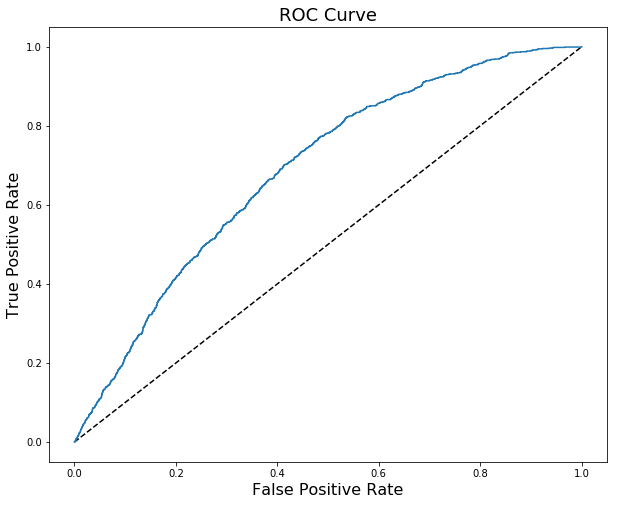



AUC: 0.6878921979819597


In [9]:
# Plot an ROC curve for the model:
y_pred_prob = clf_grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.plot([0, 1], [0, 1], 'k--')
_ = axes.plot(fpr, tpr)
_ = axes.set_xlabel('False Positive Rate', fontsize=16)
_ = axes.set_ylabel('True Positive Rate', fontsize=16)
_ = plt.title('ROC Curve', fontsize=18)
plt.show()

# Compute and print AUC score
print('\n')
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

These are some interesting but problematic results. In terms of straight accuracy, the model does a good job -- the accuracy of the modeling is 79%. But a further examination into the classification results showcases a very specific problem. The confusion matrix and classification report show that the reason for such a result is that the model is just choosing a 0 for almost every single board game. This reflects itself in the recall difference between the two classes. These properties are coming from the fact that this is an imbalanced dataset, where the difference in classes are 4:1; this problem was created when I made the cutoff for success to be the 80th percentile. 

To test if this is the case, I can change the cutoff to be 75% and 85%, and see whether or not the results track this change:

{'C': 0.001} 0.7545662100456622


0.7382537568955678
[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.76      0.99      0.86      9250
       True       0.52      0.02      0.04      3014

avg / total       0.70      0.75      0.66     12264

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.74      0.99      0.85      3890
       True       0.42      0.02      0.03      1367

avg / total       0.66      0.74      0.64      5257



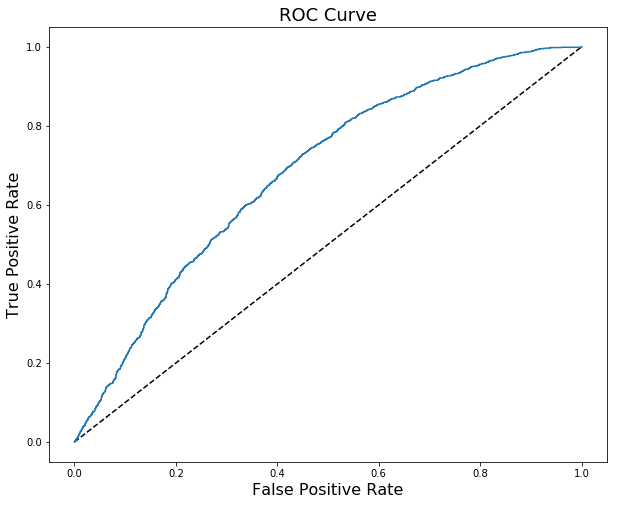



AUC: 0.6829316819711037


In [10]:
# First, let's do the 75% cutoff instead of 80%:
ratings = noNaN_DF['Rating']
target75 = ratings.apply(lambda x: x >= np.percentile(noNaN_DF['Rating'], 75))

# First, we split the data into a training and test set, using a 70-30 split:
X_train75, X_test75, y_train75, y_test75 = train_test_split(features.values, target75.values, 
                                                    test_size=0.3, random_state=42)

# Now, we can perform the grid search for the logistic regression model hyperparameter:
logreg = LogisticRegression(random_state=42)    # L2 regularlization is the default mode
clf_grid75 = GridSearchCV(logreg, {'C': C_vals}, cv=5, scoring='accuracy')
clf_grid75.fit(X_train75, y_train75)
y_predict_test75 = clf_grid75.predict(X_test75)
print(clf_grid75.best_params_, clf_grid75.best_score_)
print('\n')
print(accuracy_score(y_predict_test75, y_test75))

y_predict_train75 = clf_grid75.predict(X_train75)

print("[Training Classification Report:]")
print(classification_report(y_train75, y_predict_train75))

print("[Test Classification Report:]")
print(classification_report(y_test75, y_predict_test75))

# Plot an ROC curve for the model:
y_pred_prob75 = clf_grid75.predict_proba(X_test75)[:,1]
fpr75, tpr75, thresholds75 = roc_curve(y_test75, y_pred_prob75)

# Plot:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.plot([0, 1], [0, 1], 'k--')
_ = axes.plot(fpr75, tpr75)
_ = axes.set_xlabel('False Positive Rate', fontsize=16)
_ = axes.set_ylabel('True Positive Rate', fontsize=16)
_ = plt.title('ROC Curve', fontsize=18)
plt.show()

# Compute and print AUC score
print('\n')
print("AUC: {}".format(roc_auc_score(y_test75, y_pred_prob75)))

{'C': 0.001} 0.8529028049575995


0.8390717139052691
[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.85      1.00      0.92     10473
       True       0.20      0.00      0.00      1791

avg / total       0.76      0.85      0.79     12264

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.84      1.00      0.91      4419
       True       0.17      0.00      0.00       838

avg / total       0.73      0.84      0.77      5257



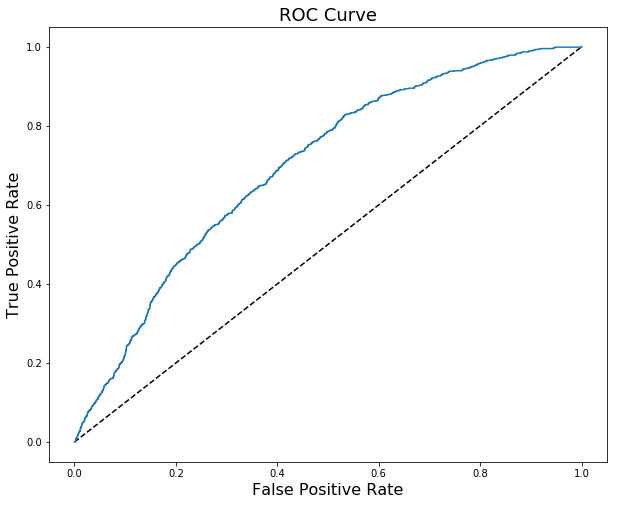



AUC: 0.6970365815655006


In [11]:
# Now, let's do the 85% cutoff instead of 80%:
ratings = noNaN_DF['Rating']
target85 = ratings.apply(lambda x: x >= np.percentile(noNaN_DF['Rating'], 85))

# First, we split the data into a training and test set, using a 70-30 split:
X_train85, X_test85, y_train85, y_test85 = train_test_split(features.values, target85.values, 
                                                    test_size=0.3, random_state=42)

# Now, we can perform the grid search for the logistic regression model hyperparameter:
logreg = LogisticRegression(random_state=42)    # L2 regularlization is the default mode
clf_grid85 = GridSearchCV(logreg, {'C': C_vals}, cv=5, scoring='accuracy')
clf_grid85.fit(X_train85, y_train85)
y_predict_test85 = clf_grid85.predict(X_test85)
print(clf_grid85.best_params_, clf_grid85.best_score_)
print('\n')
print(accuracy_score(y_predict_test85, y_test85))

y_predict_train85 = clf_grid85.predict(X_train85)

print("[Training Classification Report:]")
print(classification_report(y_train85, y_predict_train85))

print("[Test Classification Report:]")
print(classification_report(y_test85, y_predict_test85))

# Plot an ROC curve for the model:
y_pred_prob85 = clf_grid85.predict_proba(X_test85)[:,1]
fpr85, tpr85, thresholds85 = roc_curve(y_test85, y_pred_prob85)

# Plot:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.plot([0, 1], [0, 1], 'k--')
_ = axes.plot(fpr85, tpr85)
_ = axes.set_xlabel('False Positive Rate', fontsize=16)
_ = axes.set_ylabel('True Positive Rate', fontsize=16)
_ = plt.title('ROC Curve', fontsize=18)
plt.show()

# Compute and print AUC score
print('\n')
print("AUC: {}".format(roc_auc_score(y_test85, y_pred_prob85)))

As expected, the behavior of the model tracks the same as the cutoff changed. For both cutoffs, the model still classified all or almost all of the games as unsuccessful. In order to correct this, I will need to balance out the dataset. Ideally, getting more data for successful board games would balance the scales, but because I already downloaded the BGG database, it's not feasible to introduce new games to our dataset. As such, I will adopt two approaches for correction: over-sampling and under-sampling, both of which I'll explore in the next sections.

## Using SMOTE to help with the imbalance in our dataset

As stated before, the major issue we have with our dataset is that it is imbalanced -- because I consider the top 80% of games to be members of the successful class, there is a 4:1 ratio between the 0 class and 1 class respectively. This causes problems with my classifier, as it will just classify all games as the 0 class. One way to address this is to generate synthetic entries of the minority class, in this case the successful (1) board game class. To do this, I will use the SMOTE method, coded up in Python in the __[imblearn](http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/over-sampling/plot_smote.html#sphx-glr-auto-examples-over-sampling-plot-smote-py)__ module.

When using SMOTE, it's important to decide when we need to create the synthetic samples. It might seem best at first to create the synthetic samples immediately, and then split the data into training and test sets afterwords, having an even distribution in both. However, there's a problem with this: I could end up with a test set full of synthetic data. This will lead to problems in generalization of the model to new data, so instead, it's best to split off a test set first, and then use SMOTE to swell the ranks purely in the training set.

To test how well the model is doing, I will look at the confusion matrix and classification report, though the most important metric will be the recall. This will give me a good idea of how well the classifier is accurately identifying games of each class.

In [12]:
from imblearn.over_sampling import SMOTE

# Establish data set features and target:
X_before = features.values
y_before = target.values
print(X_before.shape, y_before.shape)
    
# Do a train-test split of 70-30 on the new dataset:
X_train_before, X_test_res, y_train_before, y_test_res = train_test_split(X_before, y_before, 
                                                test_size=0.3, random_state=42)
# There are 4 different SMOTE algorithms, so let's try each one:
kinds = ['regular', 'borderline1', 'borderline2', 'svm']
for k in kinds:
    
    # Use SMOTE to generate synthetic samples of the minority class:
    sm = SMOTE(kind=k, random_state=42)  # Without an input ratio, will generate until equal representation
    X_train_res, y_train_res = sm.fit_sample(X_train_before, y_train_before)
    print('SMOTE Algorithm: {}'.format(k))
    print('--------------------------------------')
    
    # Do a grid search for the best regularization parameter:
    logreg_grid = LogisticRegression(random_state=42)
    clf_res = GridSearchCV(logreg_grid, {'C': C_vals}, cv=5, scoring='accuracy')
    clf_res.fit(X_train_res, y_train_res)
    print(clf_res.best_params_, clf_res.best_score_)
    print('\n')
    
    # Retrain the logistic regression and make predictions:
    logreg_resample = LogisticRegression(C=clf_res.best_params_['C'], random_state=42)
    logreg_resample.fit(X_train_res, y_train_res)
    y_predict_train_res = logreg_resample.predict(X_train_res)
    y_predict_test_res = logreg_resample.predict(X_test_res)
    
    # Figure out the coefficients and summary statistics:
    for i in range(len(features.columns)):
        print('Coefficient for {}: {}\n'.format(features.columns[i], logreg_resample.coef_[0][i]))
    
    accuracy = accuracy_score(y_predict_test_res, y_test_res)
    print('Accuracy score: {}\n'.format(accuracy))
    print(confusion_matrix(y_predict_test_res, y_test_res))
    print('\n')
    print("[Training Classification Report:]")
    print(classification_report(y_train_res, y_predict_train_res))
    
    print("[Test Classification Report:]")
    print(classification_report(y_test_res, y_predict_test_res))

(17521, 6) (17521,)
SMOTE Algorithm: regular
--------------------------------------
{'C': 100.0} 0.6633160726977358


Coefficient for Weight: 1.0484765258876483

Coefficient for Min Playtime: -0.00555890295349277

Coefficient for Max Playtime: 0.0011856737686377294

Coefficient for Year Published: 0.027011963922219703

Coefficient for Min Players: 0.09282296919377822

Coefficient for Max Players: 0.04745229417667624

Accuracy score: 0.6528438272779151

[[2716  374]
 [1451  716]]


[Training Classification Report:]
             precision    recall  f1-score   support

      False       0.66      0.66      0.66      9849
       True       0.66      0.67      0.66      9849

avg / total       0.66      0.66      0.66     19698

[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.88      0.65      0.75      4167
       True       0.33      0.66      0.44      1090

avg / total       0.77      0.65      0.68      5257

SMOTE Algorithm: bor

So it would appear the best results I got were from using the "svm" SMOTE algorithm. This ended with an average recall of 67%. It's also worth noting that in terms of the true class recall, the "borderline-2" SMOTE algorithm performed the best, with a value of 68%, but this was at the expense of the false class recall, which was lower than that of the other models.

## Under-sampling the dataset (Small ensemble classifier)

Another way of addressing an imbalanced dataset problem is to under-sample the majority class. Given the amount of data in my dataset (roughly 17,500 entries), achieving a balance between the successful and unsuccessful board games would require me to trim my dataset way down. I don't want to delete my data completely, so instead I will create an ensemble classifier by splitting up the majority classes into groups and then taking the majority vote of each one.

To build this ensemble, it would be good to create a large number of individual classifiers; in this case, it can be accomplished by randomly sampling from my majority class so that I can create different samples for regression training. Then I can implement a weighted majority vote based on the accuracy of any particular model. For reproducability, I will need to save the classifiers (and the weights) so they can be used again with new data.

In [13]:
# Build a function for weighing the accuracy of a vote:
def accuracy_weighting(accuracy, vote):
    if vote:
        new_vote = accuracy
    else:
        new_vote = 1.0 - accuracy
    return new_vote

# Now, let's separate out the different classes in the dataset:
target.name = 'Target'
noNaN_DF = pd.concat([noNaN_DF, target], axis=1)
trues = noNaN_DF.loc[noNaN_DF.Target==True]
falses = noNaN_DF.loc[noNaN_DF.Target==False]
trues_y = trues['Target']
trues_X = trues.drop(['Rating', 'Target', 'ID Num', 'User Number', 'Standard Dev'], axis=1)
falses_y = falses['Target']
falses_X = falses.drop(['Rating', 'Target', 'ID Num', 'User Number', 'Standard Dev'], axis=1)

# Do a 80-20 train-test-split on trues and falses to build the test set:
X_train_true, X_test_true, y_train_true, y_test_true = train_test_split(trues_X.values, 
                                                    trues_y.values, test_size=0.2, random_state=42)
X_train_false, X_test_false, y_train_false, y_test_false = train_test_split(falses_X.values, 
                                                    falses_y.values, test_size=0.2, random_state=42)
X_test_folds = np.concatenate((X_test_true, X_test_false))
y_test_folds = np.concatenate((y_test_true, y_test_false))


# Now we will need to loop through the algorithm for creating a new training
# set and training the logistic regression model to save for later. Let's
# use a total of 1000 classifiers for our ensemble.

from sklearn.externals import joblib  # For pickling/unpickling models for saving
PKLPATH = 'pkl_files/'
models = []
votes = []

for j in range(1000):
    # Use train-test-split to grab a random 26% assortment of remaining training data:
    X_false_random, _1, y_false_random, _2 = train_test_split(X_train_false, 
                                                    y_train_false, test_size=0.74, random_state=j)
    X_train_random = np.concatenate((X_false_random, X_train_true)) # 3320 False, 3226 True
    y_train_random = np.concatenate((y_false_random, y_train_true))
    
    # Do a grid search to train the log regression model:
    logreg_rand = LogisticRegression(random_state=j)
    clf_rand = GridSearchCV(logreg_rand, {'C': C_vals}, cv=5, scoring='accuracy')
    clf_rand.fit(X_train_random, y_train_random)
    
    # Vote (predict) on the test set and then apply weight based on accuracy:
    prediction = clf_rand.predict(X_test_folds)
    vote = np.array(prediction, dtype=float) # Individual vote
    accuracy = accuracy_score(prediction, y_test_folds)
    vote_weighted = np.fromiter((accuracy_weighting(accuracy, v) for v in vote), float)
    
    # Save model, then place it and its vote inside the models and votes list for later:
    joblib.dump(clf_rand, '{}log_reg_rand{}.pkl'.format(PKLPATH, str(j)))
    models.append(joblib.load('{}log_reg_rand{}.pkl'.format(PKLPATH, str(j))))
    votes.append(vote_weighted)

In [14]:
# Now we have all of the models and votes collected, so we can create the ensemble vote:
ensemble_vote = np.sum(votes, axis=0)
ensemble_predict = np.zeros(len(ensemble_vote), dtype=bool)
for index, vote in enumerate(ensemble_vote):
    if vote >= 500.0:
        ensemble_predict[index] = True

# Finally, let's calculate the relevant metrics:
print('Accuracy for full ensemble: {}\n'.format(accuracy_score(ensemble_predict, y_test_folds)))
print('Confusion Matrix: \n')
print(confusion_matrix(ensemble_predict, y_test_folds))
print('\n')
print("[Test Classification Report:]")
print(classification_report(y_test_folds, ensemble_predict))

Accuracy for full ensemble: 0.670756062767475

Confusion Matrix: 

[[1939  289]
 [ 865  412]]


[Test Classification Report:]
             precision    recall  f1-score   support

      False       0.87      0.69      0.77      2804
       True       0.32      0.59      0.42       701

avg / total       0.76      0.67      0.70      3505



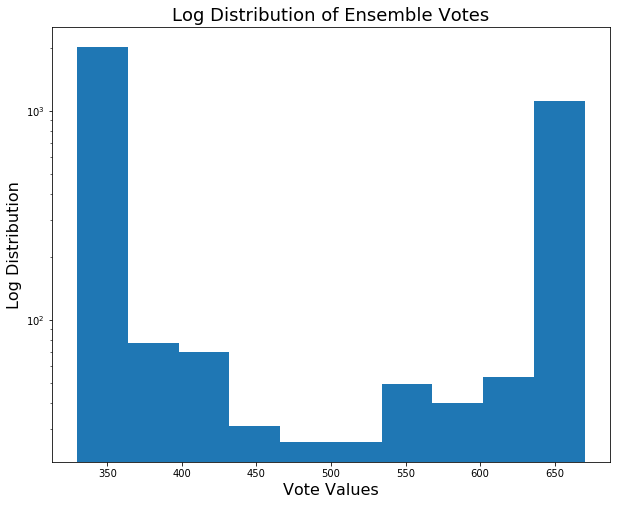

In [15]:
# Plot the distribution of ensemble votes:
fig, axes = plt.subplots(figsize=(10,8))
_ = axes.hist(ensemble_vote, bins=10)
_ = axes.set_xlabel('Vote Values', fontsize=16)
_ = axes.set_ylabel('Log Distribution', fontsize=16)
_ = axes.set_yscale('log')
_ = plt.title('Log Distribution of Ensemble Votes', fontsize=18)
plt.show()

The ensemble method seemed to show similar results to the SMOTE method, though it has less interpretability since there is no easy way to determine the coefficients for each feature. It performed slightly worse, so of the two methods, the over-sampling seems to have been overall superior. Interestingly, as shown in the plot above, most of the board games were classified with most of the ensemble in agreement, with comparatively fewer games being on the fence.

The logistic regression results are promising, though I would like to try the Random Forest classifier, as it tends to have superior accuracy than logistic regression. I'll explore that possibility in the next IPython notebook, and see how the two classifiers compare.